### Accuracy for Kaggle website test dataset : 0.77033

Accuracy for training dataset (split 30/70): 0.815980

In [1]:
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt

#importing all the required ML packages
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn import metrics #accuracy measure
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction

In [2]:
# FUNCTIONS TO PROCESS DATA

def get_title(name):
    name = name.split(". ")[0]
    name = name.split(" ")[-1]
    return(name)

def get_title_processed(name): 
    ''' Process titles to remove one-off exceptions '''
    if name in ['Ms','Mlle']:
        name = 'Miss'
    if name in ['Capt', 'Don', 'Major', 'Col', 'Sir', 'Rev']:
        name = 'Rare_M'
    if name in ['Dona', 'Lady', 'the Countess']:
        name = 'Rare_F'
    if name == 'Mme':
        name = 'Mrs'
    if name == 'Jonkheer':
        name = 'Master'
    commons = ['Mr', 'Mrs', 'Miss', 'Master', 'Rare_M', 'Rare_F']
    if name not in commons:
        name = 'Other'
    return(name)

def get_cabin(cabin):
    ''' Separate original cabin assignments into sets '''
    try: # Handle nans
        cabins = cabin.split(" ")
        letters = [x[0] for x in cabins]
        counts = collections.Counter(letters)
        new_list = sorted(letters, key=counts.get, reverse=True)
        letter = new_list[0][0]
    except: 
        letter = np.nan
    return(letter)

def get_cabin_number(cabin):
    ''' Returns the number of cabins booked '''
    try: 
        num = len(cabin.split(" "))
    except:
        num = np.nan
    return(num)

def get_ages(age):
    ''' Separate a continuous variable into classes of "cutoff" bin size'''
    cutoff = 5
    age_lim = 80
    if age > age_lim:
        age = age_lim
    age = np.round(age/cutoff)
    return(age)

def get_fare(fare):
    ''' Separate a continuous variable into classes of "cutoff" bin size'''
    cutoff = 10
    fare_lim = 100
    if fare > fare_lim:
        fare = fare_lim
    fare = np.round(fare/cutoff)
    return(fare)

def get_ticket_alpha(name):
    ''' Return just the type of ticket '''
    name = ''.join(c for c in name if c not in '?:!/;.,[]{}')
    name = name.split(" ")[0]
    if name == 'STONO':
        name = 'STONO2'
    try:
        name = float(name)
        name = 'NUMERIC'
    except: 
        pass
    return(name)

def get_ticket_number(name):
    '''Return just the number of the ticket'''
    name = ''.join(c for c in name if c not in '?:!/;.,[]{}')
    name = name.split(" ")[-1]
    try:
        name = float(name)
        name = str(name)
        name = name[0:1]
    except: 
        pass
    return(name)
    
def process_data(fname, verbose=True):
    df = pd.read_csv(fname)
    df = df.drop('PassengerId', axis=1)
    
    # Turn the passenger name into a useful variable by extracting title
    df['Title'] = df['Name'].apply(get_title)
    df['Title'] = df['Title'].apply(get_title_processed)
    df = df.drop('Name', axis=1)
    
    # Change the cabin to a more general classification
    df['Cabin_Letter'] = df['Cabin'].apply(get_cabin)
    df['Cabin_Number'] = df['Cabin'].apply(get_cabin_number)
    df = df.drop('Cabin', axis=1)
    
    # Turn age & fare into categorical variables
    df['Age'] = df['Age'].apply(get_ages)
    df['Fare'] = df['Fare'].apply(get_fare)
    
    # Turn ticket numbers into categorical variables
    df['Ticket_num'] = df['Ticket'].apply(get_ticket_number)
    df['Ticket'] = df['Ticket'].apply(get_ticket_alpha)
    
    # Separate family sizes into singletons, small, large, etc.
    df['Family_size'] = df['Parch'] + df['SibSp'] + 1
    df.loc[df['Family_size'] > 3, 'Family_size'] = 4
    
    # Random variables that may not make a difference
    df['Single_f'] = np.logical_and(df['Title']=='Miss', df['Age']>20)
    df['Alone'] = df['SibSp']+df['Parch']==0
    df['Age*Class'] = df['Age']*df['Pclass']
    df['Age*Family'] = df['Age']*df['Family_size']
    df['Family*Nums'] = df['Family_size']*df['Cabin_Number']
    
    # df = df.drop('Parch', axis=1)
    # df = df.drop('SibSp', axis=1)
    # df = df.drop('Cabin_Number', axis=1)
    # df = df.drop('Family_size', axis=1)
    
    if verbose == True:
        print('Missing data for:', fname, '(out of', len(df), 'entries)')
        print(df.isnull().sum())
        print('----')

    # Process alphabet variables into numerics
    cats = ['Title', 'Ticket_num', 'Sex', 'Embarked', 'Ticket', 'Cabin_Letter']
    for cat in cats:
        names = df[cat].unique()
        categories = np.arange(0, len(names)).tolist()
        df[cat] = df[cat].replace(to_replace=names, value=categories)

    # Impute NaNs because we can't use them in classifiers
    df = df.replace(to_replace=np.nan, value='NaN')
    imp = sklearn.preprocessing.Imputer(missing_values='NaN', strategy='most_frequent', axis=1)

    for column in df:
        data = df[column].values.reshape(-1, 1).T
        df[column] = imp.fit_transform(data).ravel()
        df[column] = df[column].astype(int)
        
    return(df)

In [3]:
# Split the training dataset into training and test subsets
# We use this to pick the correct ML classifier 
# Then we can use it on the test data which has no survival data

df = process_data('./data/titanic_train.csv', verbose=False)
train, test = train_test_split(df, test_size=0.3,
                               random_state=0, stratify=df['Survived'])

train_X=train[train.columns[1:]]
train_Y=train[train.columns[:1]]
test_X=test[test.columns[1:]]
test_Y=test[test.columns[:1]]
X = df[df.columns[1:]]
Y = df['Survived']

train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Cabin_Letter,Cabin_Number,Ticket_num,Family_size,Single_f,Alone,Age*Class,Age*Family,Family*Nums
231,0,3,0,6,0,0,3,1,0,0,0,1,2,1,0,1,18,6,1
836,0,3,0,4,0,0,3,1,0,0,0,1,2,1,0,1,12,4,1
639,0,3,0,4,1,0,3,2,0,0,0,1,2,2,0,0,12,4,1
389,1,2,1,3,0,0,23,1,1,2,0,1,1,1,0,1,6,3,1
597,0,3,0,10,0,0,18,0,0,0,0,1,9,1,0,1,30,10,1


                      CV Mean       Std
Random Forest        0.826067  0.038521
Logistic Regression  0.808090  0.020280
Linear Svm           0.804719  0.032603
Naive Bayes          0.772235  0.030333
Decision Tree        0.767740  0.032780
KNN                  0.766642  0.048874
Radial Svm           0.764345  0.035614


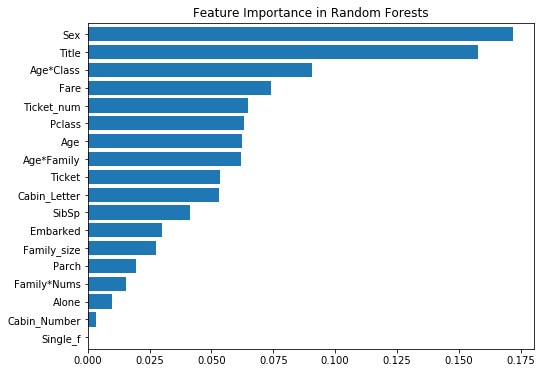

In [4]:
# Run a bunch of different classifiers to see which works best

kfold = KFold(n_splits=10, random_state=22) # k=10, split the data into 10 equal parts
xyz=[]
accuracy=[]
std=[]
classifiers=['Linear Svm','Radial Svm','Logistic Regression','KNN',
             'Decision Tree','Naive Bayes','Random Forest']
models=[svm.SVC(kernel='linear'),svm.SVC(kernel='rbf'),LogisticRegression(),
        KNeighborsClassifier(n_neighbors=9),DecisionTreeClassifier(),
        GaussianNB(),RandomForestClassifier(n_estimators=100)]
for i in models:
    model = i
    cv_result = cross_val_score(model, X, Y, cv = kfold,scoring = "accuracy")
    cv_result=cv_result
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)
    
new_models_dataframe2 = pd.DataFrame({'CV Mean':xyz,'Std':std},index=classifiers)   
output = new_models_dataframe2.sort_values(by='CV Mean', ascending=False)
print(output)

# Random forests seem to work best so let's look at the variables
model=RandomForestClassifier(n_estimators=100,random_state=0)
model.fit(X,Y)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax)
ax.set_title('Feature Importance in Random Forests')
plt.show()
plt.close('all')

In [5]:
# Now that we've checked the accuracy of the ML model on a subset
# of the training data, apply it to the test data to see if it works.

train_df = process_data('./data/titanic_train.csv', verbose=False)
test_df = process_data('./data/titanic_test.csv', verbose=False)

train_X = train_df.copy()
train_X = train_X.drop('Survived', axis=1)
train_Y = train_df['Survived']

model=RandomForestClassifier(n_estimators=100)
model.fit(train_X, train_Y)
prediction = model.predict(test_df)

submission_df = pd.read_csv('./data/titanic_test.csv')
submission_df['Survived'] = prediction
submission_df.Survived = submission_df.Survived.astype(int)
submission_df = submission_df[['PassengerId', 'Survived']]

print(submission_df[:5])
print('-----')
print('Submission should be 418 lines, and is', len(submission_df))

submission_df.to_csv('./data/EL_titanic_submission.csv', index=False)

   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0
-----
Submission should be 418 lines, and is 418
